Import libraries

In [ ]:
from __future__ import print_function
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle
import csv
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torchvision import datasets, transforms
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

!mkdir data
!mkdir data/test_images
!mkdir data/val_images
!mkdir data/train_images
%cd data
CUDA_LAUNCH_BLOCKING=1

/content/data


Get data

In [ ]:
!wget https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
!unzip traffic-signs-data.zip
# ! wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv

--2021-03-09 07:34:45--  https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 13.224.8.160, 13.224.8.22, 13.224.8.111, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|13.224.8.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘traffic-signs-data.zip’

traffic-signs-data. 100%[===================>] 117.80M  35.4MB/s    in 3.8s    

2021-03-09 07:34:49 (31.2 MB/s) - ‘traffic-signs-data.zip’ saved [123524425/123524425]

Archive:  traffic-signs-data.zip
  inflating: test.p                  
  inflating: train.p                 
  inflating: valid.p                 


Transforms

In [ ]:
# data augmentation for training and test time
# Resize all images to 32 * 32 and normalize them to mean = 0 and standard-deviation = 1 based on statistics collected from the training set

data_transforms = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

# Resize, normalize and jitter image brightness
data_jitter_brightness = transforms.Compose([
	  transforms.Resize((32, 32)),
    transforms.ColorJitter(brightness=5),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

# Resize, normalize and jitter image saturation
data_jitter_saturation = transforms.Compose([
	  transforms.Resize((32, 32)),
    transforms.ColorJitter(saturation=5),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

# Resize, normalize and jitter image contrast
data_jitter_contrast = transforms.Compose([
	  transforms.Resize((32, 32)),
    transforms.ColorJitter(contrast=5),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

# Resize, normalize and jitter image hues
data_jitter_hue = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.ColorJitter(hue=0.4),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

# Resize, normalize and rotate image
data_rotate = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

# Resize, normalize and flip image horizontally and vertically
data_hvflip = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(1),
    transforms.RandomVerticalFlip(1),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

# Resize, normalize and flip image horizontally
data_hflip = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(1),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

# Resize, normalize and flip image vertically
data_vflip = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomVerticalFlip(1),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

# Resize, normalize and shear image
data_shear = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomAffine(degrees = 15,shear=2),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

# Resize, normalize and translate image
data_translate = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomAffine(degrees = 15,translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

# Resize, normalize and crop image 
data_center = transforms.Compose([
	transforms.Resize((36, 36)),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

# Resize, normalize and convert image to grayscale
data_grayscale = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

In [ ]:
training_file = "./train.p"
validation_file= "./valid.p"
testing_file = "./test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# signs = []
# with open('signnames.csv', 'r') as csvfile:
#     signnames = csv.reader(csvfile, delimiter=',')
#     next(signnames,None)
#     for row in signnames:
#         signs.append(row[1])
#     csvfile.close()

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# Number of validation examples.
n_validation = X_valid.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples: ", n_train)
print("Number of testing examples: ", n_test)
print("Number of validation examples: ", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples:  34799
Number of testing examples:  12630
Number of validation examples:  4410
Image data shape = (32, 32, 3)
Number of classes = 43


File to images

In [ ]:
for num, image in enumerate(X_train):
    image = np.ascontiguousarray(image)
    img = Image.fromarray(image, 'RGB')
    if not os.path.exists('train_images/{label}'.format(label = str(y_train[num]))):
      os.mkdir('train_images/{label}'.format(label = str(y_train[num])))
    img.save("./train_images/{label}/{i}.jpg".format(i = num, label = str(y_train[num])))
      

In [ ]:
for num, image in enumerate(X_test):
    image = np.ascontiguousarray(image)
    img = Image.fromarray(image, 'RGB')
    if not os.path.exists('test_images/{label}'.format(label = str(y_test[num]))):
      os.mkdir('test_images/{label}'.format(label = str(y_test[num])))
    img.save("./test_images/{label}/{i}.jpg".format(i = num, label = str(y_test[num])))

In [ ]:
for num, image in enumerate(X_valid):
    image = np.ascontiguousarray(image)
    img = Image.fromarray(image, 'RGB')
    if not os.path.exists('val_images/{label}'.format(label = str(y_valid[num]))):
      os.mkdir('val_images/{label}'.format(label = str(y_valid[num])))
    img.save("./val_images/{label}/{i}.jpg".format(i = num, label = str(y_valid[num])))

In [ ]:
if torch.cuda.is_available():
    use_gpu = True
    print("Using GPU")
else:
	use_gpu = False
	print("Using CPU")
 
FloatTensor = torch.cuda.FloatTensor if use_gpu else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_gpu else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_gpu else torch.ByteTensor
Tensor = FloatTensor

Using GPU


Dataloaders and dataset

In [ ]:
train_loader = torch.utils.data.DataLoader(
   torch.utils.data.ConcatDataset([datasets.ImageFolder('./train_images', 
   transform=data_transforms)]), batch_size=64, shuffle=True, num_workers=4, pin_memory=use_gpu)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('./val_images',
                         transform=data_transforms),
    batch_size=4410, shuffle=False, num_workers=4, pin_memory=use_gpu)

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('./test_images',
                         transform=data_transforms),
    batch_size=12630, shuffle=False, num_workers=4, pin_memory=use_gpu)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
nclasses = 43 # GTSRB as 43 classes

MODEL

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv2d(3, 100, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(100)
        self.conv2 = nn.Conv2d(100, 150, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(250)
        self.conv_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(250*2*2, 350)
        self.fc2 = nn.Linear(350, nclasses)

        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
            )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 4 * 4, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
            )
   
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))


    # Spatial transformer model forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def compute_features(self, x):
        # transform the input
        x = self.stn(x)
        self.datain = x
        # Perform forward pass
        x = self.bn1(F.max_pool2d(F.leaky_relu(self.conv1(x)),2))
        x = self.conv_drop(x)
        x = self.bn2(F.max_pool2d(F.leaky_relu(self.conv2(x)),2))
        x = self.conv_drop(x)
        x = self.bn3(F.max_pool2d(F.leaky_relu(self.conv3(x)),2))
        x = self.conv_drop(x)
        x = x.view(-1, 250*2*2)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=0.5)
        return x


class CNN_DUQ(Net):
    def __init__(
        self,
        input_size,
        num_classes,
        centroid_size,
        model_output_size,
        length_scale,
        gamma,
        input_dep_ls=False
    ):
        super().__init__()

        self.gamma = gamma
        self.input_dep_ls=input_dep_ls

        self.W = nn.Parameter(
            torch.zeros(centroid_size, num_classes, model_output_size)
        )
        nn.init.kaiming_normal_(self.W, nonlinearity="relu")


        self.register_buffer("N", torch.zeros(num_classes) + 13)
        self.register_buffer(
            "m", torch.normal(torch.zeros(centroid_size, num_classes), 0.05)
        )
        self.m = self.m * self.N
        
        if input_dep_ls:
            self.sigmann=nn.Linear(model_output_size,1)
        self.sigma = length_scale

    def rbf(self, z):
    
        if self.input_dep_ls:
            self.sigma = torch.sigmoid(self.sigmann(z))+0.01
            
        z = torch.einsum("ij,mnj->imn", z, self.W)

        embeddings = self.m / self.N.unsqueeze(0)

        diff = z - embeddings.unsqueeze(0)
        diff = (diff ** 2).mean(1).div(2 * self.sigma ** 2).mul(-1).exp()

        return diff

    def update_embeddings(self, x, y):
        self.N = self.gamma * self.N + (1 - self.gamma) * y.sum(0)

        z = self.compute_features(x)

        z = torch.einsum("ij,mnj->imn", z, self.W)
        embedding_sum = torch.einsum("ijk,ik->jk", z, y)

        self.m = self.gamma * self.m + (1 - self.gamma) * embedding_sum

    def forward(self, x):
        z = self.compute_features(x)
        y_pred = self.rbf(z)

        return y_pred

length_scale = 2
input_size = 32
num_classes = 43
output_size = 350
embedding_size = 100
learnable_length_scale = False #Learnable length scale
gamma = 0.999
input_dep_ls = True
model = CNN_DUQ(input_size,num_classes,embedding_size,output_size,length_scale,gamma,input_dep_ls).float().cuda()

def calc_gradient_penalty(x, y_pred_sum):
    gradients = torch.autograd.grad(
        outputs=y_pred_sum,
        inputs=x,
        grad_outputs=torch.ones_like(y_pred_sum),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients = gradients.flatten(start_dim=1)

    # L2 norm
    grad_norm = gradients.norm(2, dim=1)

    # Two sided penalty
    gradient_penalty = ((grad_norm - 1) ** 2).mean()

    return gradient_penalty

In [ ]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=0.001,weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=2,factor=0.5,verbose=True)

In [ ]:
def train(epoch,lm):
    
    correct = 0
    training_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        model.train()
        data, target = Variable(data), Variable(target)
        if use_gpu:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = 10*F.binary_cross_entropy(output, F.one_hot(target.long(),43).float()) + lm*calc_gradient_penalty(model.datain,output.sum(1))
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            model.update_embeddings(data,F.one_hot(target.long(),43).float())
        max_index = output.max(dim = 1)[1]
        correct += (max_index == target).sum()
        training_loss += loss
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss per example: {:.6f}\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.data.item()/(640),loss.data.item()))
    print('\nTraining set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                training_loss / len(train_loader.dataset), correct, len(train_loader.dataset),
                100. * correct / len(train_loader.dataset)))
def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
            if use_gpu:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            validation_loss += F.cross_entropy(output, target, size_average=False).data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    scheduler.step(np.around(validation_loss,2))
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))

In [ ]:
lm = 0.1
for epoch in range(1, 11):
    train(epoch,lm)
    validation()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

Train Epoch: 1 [0/34799 (0%)]	Loss per example: 0.048877	Loss: 31.281532
Train Epoch: 1 [640/34799 (2%)]	Loss per example: 0.008511	Loss: 5.447052
Train Epoch: 1 [1280/34799 (4%)]	Loss per example: 0.002713	Loss: 1.736096
Train Epoch: 1 [1920/34799 (6%)]	Loss per example: 0.002254	Loss: 1.442389
Train Epoch: 1 [2560/34799 (7%)]	Loss per example: 0.002185	Loss: 1.398486
Train Epoch: 1 [3200/34799 (9%)]	Loss per example: 0.001952	Loss: 1.249493
Train Epoch: 1 [3840/34799 (11%)]	Loss per example: 0.001935	Loss: 1.238140
Train Epoch: 1 [4480/34799 (13%)]	Loss per example: 0.002003	Loss: 1.281778
Train Epoch: 1 [5120/34799 (15%)]	Loss per example: 0.001927	Loss: 1.233404
Train Epoch: 1 [5760/34799 (17%)]	Loss per example: 0.001757	Loss: 1.124660
Train Epoch: 1 [6400/34799 (18%)]	Loss per example: 0.001815	Loss: 1.161748
Train Epoch: 1 [7040/34799 (20%)]	Loss per example: 0.001852	Loss: 1.185093
Train Epoch: 1 [7680/34799 (22%)]	Loss per example: 0.001844	Loss: 1.180054
Train Epoch: 1 [8320/

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Validation set: Average loss: 3.3437, Accuracy: 2664/4410 (60%)

Train Epoch: 2 [0/34799 (0%)]	Loss per example: 0.001053	Loss: 0.674231
Train Epoch: 2 [640/34799 (2%)]	Loss per example: 0.000957	Loss: 0.612720
Train Epoch: 2 [1280/34799 (4%)]	Loss per example: 0.000848	Loss: 0.542792
Train Epoch: 2 [1920/34799 (6%)]	Loss per example: 0.000881	Loss: 0.563530
Train Epoch: 2 [2560/34799 (7%)]	Loss per example: 0.000982	Loss: 0.628753
Train Epoch: 2 [3200/34799 (9%)]	Loss per example: 0.000949	Loss: 0.607194
Train Epoch: 2 [3840/34799 (11%)]	Loss per example: 0.001089	Loss: 0.696857
Train Epoch: 2 [4480/34799 (13%)]	Loss per example: 0.000801	Loss: 0.512515
Train Epoch: 2 [5120/34799 (15%)]	Loss per example: 0.000859	Loss: 0.549890
Train Epoch: 2 [5760/34799 (17%)]	Loss per example: 0.000855	Loss: 0.546901
Train Epoch: 2 [6400/34799 (18%)]	Loss per example: 0.000752	Loss: 0.480962
Train Epoch: 2 [7040/34799 (20%)]	Loss per example: 0.000826	Loss: 0.528324
Train Epoch: 2 [7680/34799 (22%)

In [ ]:
def test():
  model.eval()
  correct = 0
  for data, target in test_loader:
      with torch.no_grad():
          data, target = Variable(data), Variable(target)
          if use_gpu:
              data = data.cuda()
              target = target.cuda()
          output = model(data)
          pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
          f1=f1_score(target.long().cpu().numpy(),pred.cpu().numpy(),average="macro")
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

  print('\nTest set: F1-score: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      f1, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [ ]:
test()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali


Test set: F1-score: 0.9557, Accuracy: 12252/12630 (97%)



# **Visualizing STN**

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

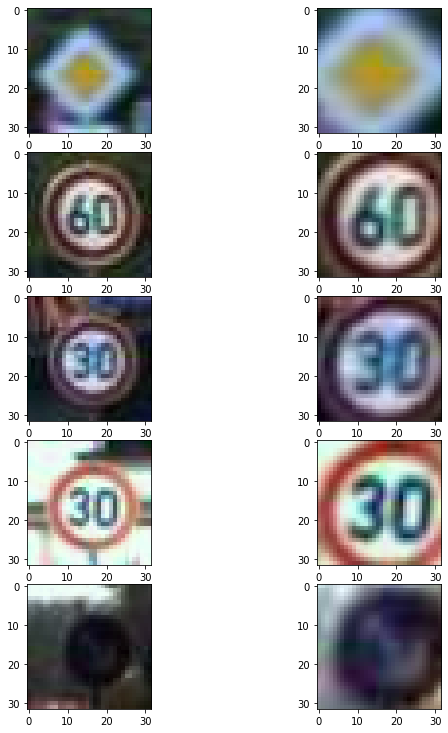

In [ ]:
for i, (data,target) in enumerate(train_loader):
  break
model.eval()
a = data[:,:,:,:].detach()
b = model.stn(data[:,:,:,:].cuda()).cpu().detach()[:,:,:,:]
c = target.long()

def norm (a):
    a = (a-a.min())
    a/=(a.max())
    return a+0.00001


num=5
plt.figure(figsize=(10,2*num))
for i in range(num):
  a[i]=norm(a[i])
  b[i]=norm(b[i])
  plt.subplot(num,2,i*2+1)
  plt.imshow(a[i].permute(1,2,0))
  plt.subplot(num,2,i*2+2)
  plt.imshow(b[i].permute(1,2,0))
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()


# **Uncertainty Analysis**

Histogram of confidence estimates for correct, wrong classifications, and also for OoD samples

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

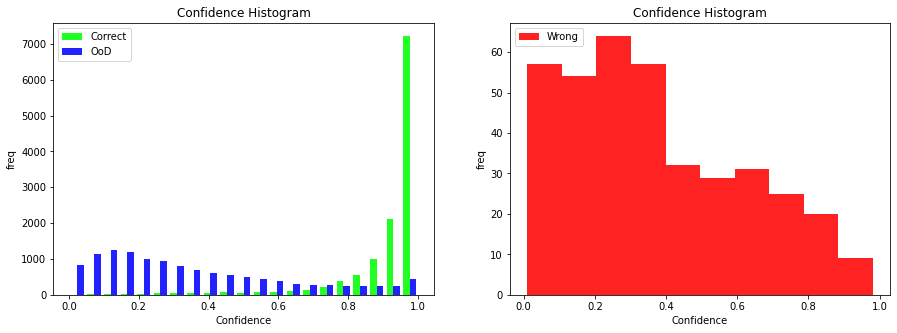

In [ ]:
kernel_distace_normal,kernel_distace_wrong,kernel_distace_ood = [],[],[]
model.eval()

e=2
with torch.no_grad():
  for _,(data, target) in enumerate(test_loader):
    output = model(data.cuda())
    output = output.cpu()
    pred = output.argmax(1)
  ood = data + e*torch.randn(data.shape)
  new_output = model(ood.cuda())
  new_output = new_output.cpu();
  newpred = new_output.argmax(1)

for i in range (len(target)):
  if target[i] == pred [i]:
    kernel_distace_normal.append(output[i].max(0)[0].item())
  else:
    kernel_distace_wrong.append(output[i].max(0)[0].item())
kernel_distace_ood = new_output.max(1)[0].tolist()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
n, bins, patches = plt.hist(x=[kernel_distace_normal,kernel_distace_ood], bins='auto', color=['#22FF22','#2222FF'])
plt.xlabel("Confidence"); plt.ylabel("freq"); plt.title("Confidence Histogram")
plt.legend(['Correct','OoD'],loc='upper left')
plt.subplot(1,2,2)
n, bins, patches = plt.hist(x=[kernel_distace_wrong], bins='auto', color=['#FF2222'])
plt.xlabel("Confidence"); plt.ylabel("freq"); plt.title("Confidence Histogram")
plt.legend(['Wrong'],loc='upper left')
plt.show()

Class Estimates for epistemic and aleatoric uncertainties

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

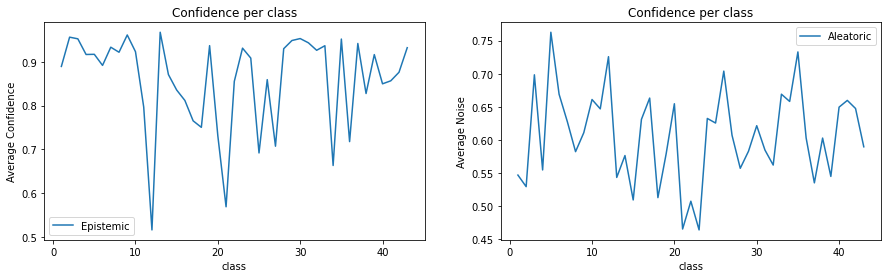

In [ ]:
model.eval()
with torch.no_grad():
  for _,(data, target) in enumerate(test_loader):
    output = model(data.cuda())
    output = output.cpu(); 
    sigma = model.sigma.cpu()
    target = target.long()

epistemic = np.empty((n_classes, 0)).tolist()
aleatoric = np.empty((n_classes, 0)).tolist()
for i in range (len(target)):
  epistemic[target[i].item()].append(output[i].max(0)[0].item())
  aleatoric[target[i].item()].append(sigma[i].item())
for i in range (n_classes):
  epistemic[i] = np.array(epistemic[i]).mean()
  aleatoric[i] = np.array(aleatoric[i]).mean()


x = np.arange(1,n_classes+1)
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(x, epistemic, label = "Epistemic")
plt.xlabel("class"); plt.ylabel("Average Confidence"); plt.title("Confidence per class");
plt.legend()

plt.subplot(1,2,2) 
plt.plot(x, aleatoric, label = "Aleatoric") 
plt.xlabel("class"); plt.ylabel("Average Noise"); plt.title("Confidence per class");
plt.legend()
plt.show()

Show uncertainties per Sample

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


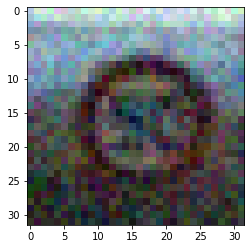

uncertainty = 0.992, noise = 0.571


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [ ]:
def norm (a):
    a = (a-a.min())
    a/=(a.max()+0.00000001)
    return a

e=1
for i, (data,target) in enumerate(train_loader):
  break
sample = data[0]+e*torch.rand(data[0].shape)
plt.imshow(norm(sample).permute(1,2,0))
plt.show()

model.eval()
output = model(sample.view(1,3,32,32).cuda()).cpu().view(-1)
epistemic, aleatoric = output.max(0)[0].item(), model.sigma[0].item()
print("uncertainty = {:.3f}, noise = {:.3f}".format(epistemic, aleatoric))